In [2]:
import pandas as pd
import collections
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import statistics
import scipy, scipy.stats
from scipy.stats import binom
from scipy.stats import skewnorm
import math

In [3]:
### LOAD DATAFRAMES

df_all = pd.read_pickle('../Desktop/saved_dataframes/Store_subset_allprojects.pkl')
df_success = pd.read_pickle('../Desktop/saved_dataframes/Store_subset_successprojects.pkl')
df_fail = pd.read_pickle('../Desktop/saved_dataframes/Store_subset_failprojects.pkl')


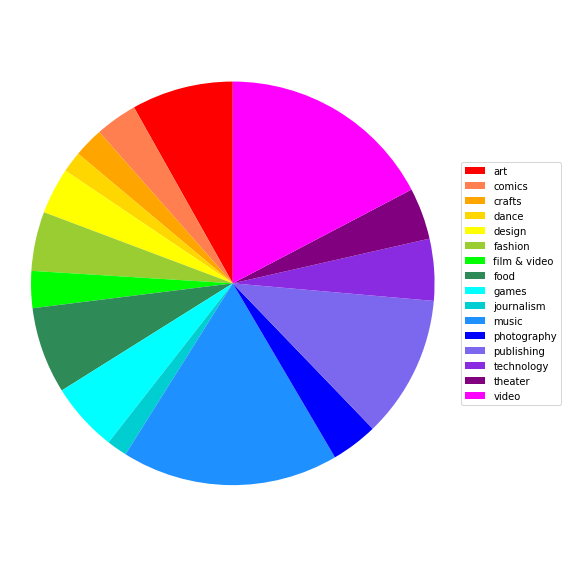

{'art': 10134, 'comics': 4182, 'crafts': 2979, 'dance': 2079, 'design': 4608, 'fashion': 5902, 'film & video': 3684, 'food': 8631, 'games': 6895, 'journalism': 2028, 'music': 21624, 'photography': 4657, 'publishing': 14204, 'technology': 6160, 'theater': 5141, 'video': 21542}


In [4]:
### ALL CATEGORIES PIE CHART

fig = plt.figure(figsize=(8, 8))
category_freq = df_all['category'].value_counts().to_dict()
category_freq = dict(sorted(category_freq.items()))
colors = ['red','coral','orange','gold','yellow','yellowgreen','lime','seagreen','cyan','darkturquoise','dodgerblue','blue','mediumslateblue','blueviolet','purple','magenta']
patches, texts = plt.pie(category_freq.values(), colors = colors, startangle=90)
plt.legend(patches, category_freq.keys(), loc="center right", bbox_to_anchor=(1.25, 0.5))
plt.axis('equal')
plt.tight_layout()
plt.show()

print(category_freq)

In [5]:
from datetime import timedelta
from datetime import datetime

In [6]:
### COMPETITION VS. NON-COMPETITION

# per subcategory
category_multi_projects = []
category_single_projects = []

category_all_freq = df_all['category_name'].value_counts().to_dict()
category_success_freq = df_success['category_name'].value_counts().to_dict()

# creating list of categories with more than one project
for i in category_all_freq:
    if category_all_freq[i] > 1:
        category_multi_projects.append(i)
    else:
        category_single_projects.append(i)
        
category_success_rate = {}
for j in list(category_all_freq.keys()):
    if j in category_success_freq.keys():
        category_success_rate[j] = category_success_freq[j] / category_all_freq[j]
    else: # no successes in these categories
        category_success_rate[j] = 0

df_all_multi = df_all.loc[df_all['category_name'].isin(category_multi_projects)]
df_all_single = df_all.loc[df_all['category_name'].isin(category_single_projects)]

df_all_c = pd.DataFrame() # competition
df_all_nc = pd.DataFrame() # no competition
for j in category_multi_projects:
    temp = df_all_multi.loc[df_all_multi['category_name'] == j]
    temp['overlap'] = (temp['deadline'].shift() - temp['created_at']) > timedelta(0)
    temp1 = temp.loc[temp['overlap'] == True]
    temp2 = temp.loc[temp['overlap'] == False]
    if len(temp1) > 0:
        df_all_c = df_all_c.append(temp1, sort = True) # overlapping projects within category
    if len(temp2) > 0:
        df_all_nc = df_all_nc.append(temp2, sort = True) # non-overlapping projects within category

df_all_nc = df_all_nc.append(df_all_single, sort = True) # single + non-overlapping projects

# remove duplicates
df_all_c = df_all_c.drop_duplicates('id')
df_all_nc = df_all_nc.drop_duplicates('id')
            
df_success_c = df_all_c.loc[df_all_c['state'] == 'successful'] # successful subset for competing projects
df_fail_c = df_all_c.loc[~(df_all_c['state'] == 'successful')] # failed subset for competing projects
df_fail_c = df_fail_c.loc[df_fail_c['P/G'] <= 1] # remove bad data
df_success_nc = df_all_nc.loc[df_all_nc['state'] == 'successful'] # successful subset for non-competing projects
df_fail_nc = df_all_nc.loc[~(df_all_nc['state'] == 'successful')] # failed subset for non-competing projects
df_fail_nc = df_fail_nc.loc[df_fail_nc['P/G'] <= 1] # remove bad data

category_all_c_freq = df_all_c['category_name'].value_counts().to_dict()
category_success_c_freq = df_success_c['category_name'].value_counts().to_dict()
category_fail_c_freq = df_fail_c['category_name'].value_counts().to_dict()
category_all_nc_freq = df_all_nc['category_name'].value_counts().to_dict()
category_success_nc_freq = df_success_nc['category_name'].value_counts().to_dict()
category_fail_nc_freq = df_fail_nc['category_name'].value_counts().to_dict()

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Number of total projects: 124450
Number of competitive projects: 66483
Number of successful competitive projects: 27737
Number of failed competitive projects: 38679
Number of non-competitive projects: 57967
Number of failed non-competitive projects: 25428
Number of success non-competitive projects: 32480

Mean duration for all competitive projects (days): 
1.2971
Median duration for all competitive projects (days): 
1.2531
Mean duration for all non-competitive projects (days): 
1.2839
Median duration for all non-competitive projects (days): 
1.2434


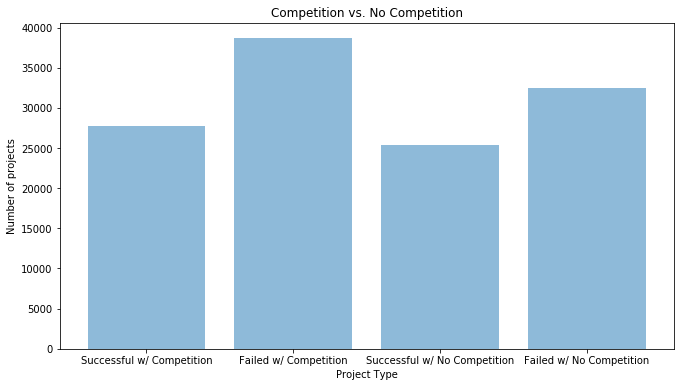

In [7]:
print('Number of total projects: ' + str(len(df_all)))
print('Number of competitive projects: ' + str(len(df_all_c)))
print('Number of successful competitive projects: ' + str(len(df_success_c)))
print('Number of failed competitive projects: ' + str(len(df_fail_c)))
print('Number of non-competitive projects: ' + str(len(df_all_nc)))
print('Number of failed non-competitive projects: ' + str(len(df_success_nc)))
print('Number of success non-competitive projects: ' + str(len(df_fail_nc)))

print()
print('Mean duration for all competitive projects (days): ')
print(round(np.mean(list(df_all_c['duration'])), 4))
print('Median duration for all competitive projects (days): ')
print(round(statistics.median(list(df_all_c['duration'])), 4))
print('Mean duration for all non-competitive projects (days): ')
print(round(np.mean(list(df_all_nc['duration'])), 4))
print('Median duration for all non-competitive projects (days): ')
print(round(statistics.median(list(df_all_nc['duration'])), 4))

objects = ('Successful w/ Competition', 'Failed w/ Competition', 
           'Successful w/ No Competition', 'Failed w/ No Competition')
fig = plt.figure(figsize = (11,6))
y_pos = np.arange(len(objects))
performance = [len(df_success_c), len(df_fail_c), len(df_success_nc), len(df_fail_nc)]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Project Type')
plt.ylabel('Number of projects')
plt.title('Competition vs. No Competition')
plt.show()

Competition


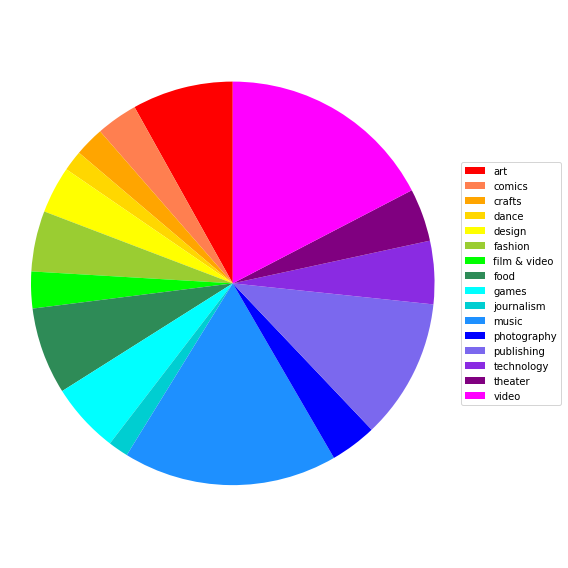

{'art': 5381, 'comics': 2211, 'crafts': 1579, 'dance': 1092, 'design': 2504, 'fashion': 3227, 'film & video': 1955, 'food': 4631, 'games': 3737, 'journalism': 1073, 'music': 11412, 'photography': 2475, 'publishing': 7479, 'technology': 3363, 'theater': 2817, 'video': 11547}

No Competition


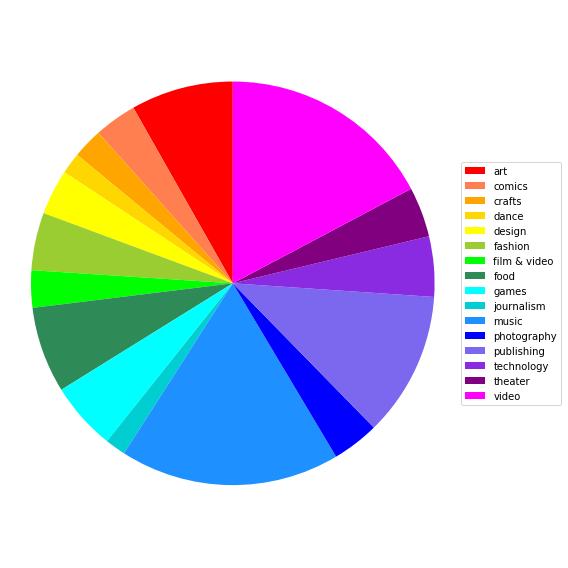

{'art': 4753, 'comics': 1971, 'crafts': 1400, 'dance': 987, 'design': 2104, 'fashion': 2675, 'film & video': 1729, 'food': 4000, 'games': 3158, 'journalism': 955, 'music': 10212, 'photography': 2182, 'publishing': 6725, 'technology': 2797, 'theater': 2324, 'video': 9995}


In [8]:
### ALL CATEGORIES PIE CHART COMPETITION VS NON-COMPETITION

print('Competition')
fig1 = plt.figure(figsize=(8, 8))
category_c_freq = df_all_c['category'].value_counts().to_dict()
category_c_freq = dict(sorted(category_c_freq.items()))
colors = ['red','coral','orange','gold','yellow','yellowgreen','lime','seagreen','cyan','darkturquoise','dodgerblue','blue','mediumslateblue','blueviolet','purple','magenta']
patches, texts = plt.pie(category_c_freq.values(), colors = colors, startangle=90)
plt.legend(patches, category_c_freq.keys(), loc="center right", bbox_to_anchor=(1.25, 0.5))
plt.axis('equal')
plt.tight_layout()
plt.show()
print(category_c_freq)

print()
print('No Competition')
fig2 = plt.figure(figsize=(8, 8))
category_nc_freq = df_all_nc['category'].value_counts().to_dict()
category_nc_freq = dict(sorted(category_nc_freq.items()))
colors = ['red','coral','orange','gold','yellow','yellowgreen','lime','seagreen','cyan','darkturquoise','dodgerblue','blue','mediumslateblue','blueviolet','purple','magenta']
patches, texts = plt.pie(category_nc_freq.values(), colors = colors, startangle=90)
plt.legend(patches, category_nc_freq.keys(), loc="center right", bbox_to_anchor=(1.25, 0.5))
plt.axis('equal')
plt.tight_layout()
plt.show()
print(category_nc_freq)


In [9]:
from collections import namedtuple

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


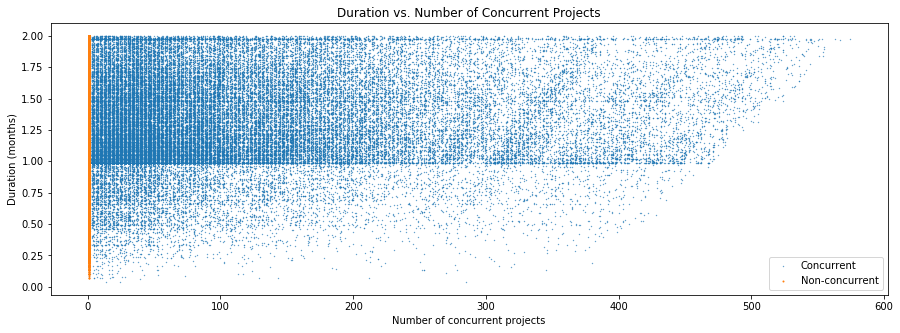

In [9]:
### NUMBER OF CONCURRENT PROJECTS VS. DURATION

Range = namedtuple('Range', ['start', 'end'])

concurrent = []
curr_duration = []

for j in list(category_all_c_freq.keys()):
    count = 0
    temp = df_all_c.loc[df_all_c['category_name'] == j]
    temp.sort_values(['deadline'], ascending = [True], inplace = True)

    lst_start = list(temp['created_at'])
    lst_end = list(temp['deadline'])
    for i in range(len(lst_start)):
        r1 = Range(start=lst_start[i], end=lst_end[i])
        count_concurrent = 1
        curr_duration.append(lst_end[i] - lst_start[i])
        for j in range(len(lst_start)):
            if i != j:
                r2 = Range(start=lst_start[j], end=lst_end[j])
                latest_start = max(r1.start, r2.start)
                earliest_end = min(r1.end, r2.end)
                delta = ((earliest_end - latest_start).days/30) + 1
                overlap = max(0, delta)
                if overlap > 0:
                    count_concurrent += 1
        concurrent.append(count_concurrent)
    
months = []
for i in curr_duration:
    months.append(i/ np.timedelta64(1,'M'))

fig = plt.figure(figsize = (15,5))
plt.scatter(concurrent, months, s=0.1)

months1 = []
lst_start = list(df_all_nc['created_at'])
lst_end = list(df_all_nc['deadline'])

for i in range(len(lst_start)):
    months1.append((lst_end[i] - lst_start[i])/ np.timedelta64(1,'M'))
plt.scatter([1] * len(months1), months1, s=1)
plt.title('Duration vs. Number of Concurrent Projects')
plt.xlabel('Number of concurrent projects')
plt.ylabel('Duration (months)')
plt.legend(['Concurrent', 'Non-concurrent'])

In [10]:
def mean_confidence_interval(data, confidence):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

Probability of success conditional on competition: 0.4172043981168118
Probability of success conditional on no competition: 0.43866337743888767


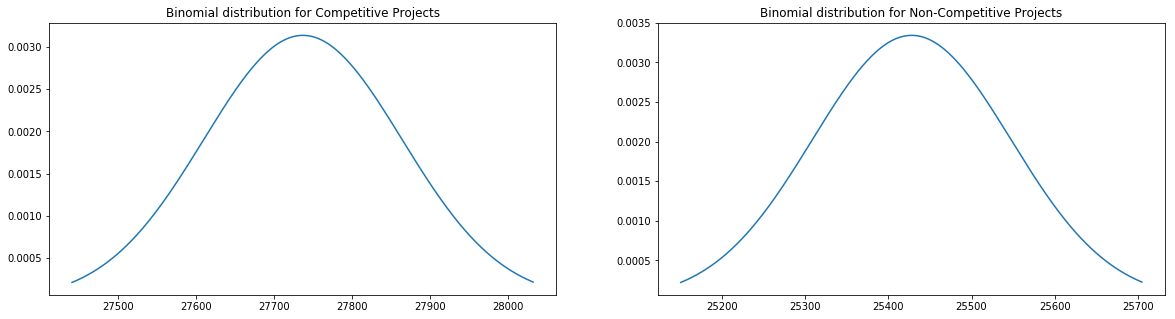

In [11]:
# probability of success conditional on competition
success_rate_c = len(df_success_c) / len(df_all_c)
print("Probability of success conditional on competition: " + str(success_rate_c))

# probability of success conditional on no competition
success_rate_nc = len(df_success_nc) / len(df_all_nc)
print("Probability of success conditional on no competition: " + str(success_rate_nc))

# binomial: 1 for success, 0 for failure
binomial_c = [1]*len(df_success_c) + [0]*len(df_fail_c)
binomial_nc = [1]*len(df_success_nc) + [0]*len(df_fail_nc)

fig = plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
s1, n1, p1 = len(df_success_c), len(binomial_c), np.mean(binomial_c)
mean1, var1, skew1, kurt1 = binom.stats(n1, p1, moments = 'mvsk')
x1 = np.arange(binom.ppf(0.01, n1, p1), binom.ppf(0.99, n1, p1))
plt.plot(x1, binom.pmf(x1, n1, p1))
plt.title('Binomial distribution for Competitive Projects')
s2, n2, p2 = len(df_success_nc), len(binomial_nc), np.mean(binomial_nc)
mean2, var2, skew2, kurt2 = binom.stats(n2, p2, moments = 'mvsk')
x2 = np.arange(binom.ppf(0.01, n2, p2), binom.ppf(0.99, n2, p2))
plt.subplot(1,2,2)
plt.plot(x2, binom.pmf(x2, n2, p2))
plt.title('Binomial distribution for Non-Competitive Projects')
plt.show()


Successful vs. failed projects goal confidence interval ($)
(6408.400052666228, 6340.479946922814, 6476.320158409641)
(10029.806429715827, 9946.499164793902, 10113.113694637752)


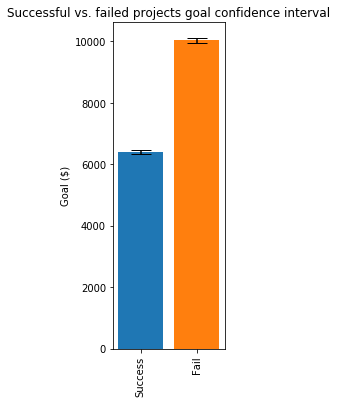

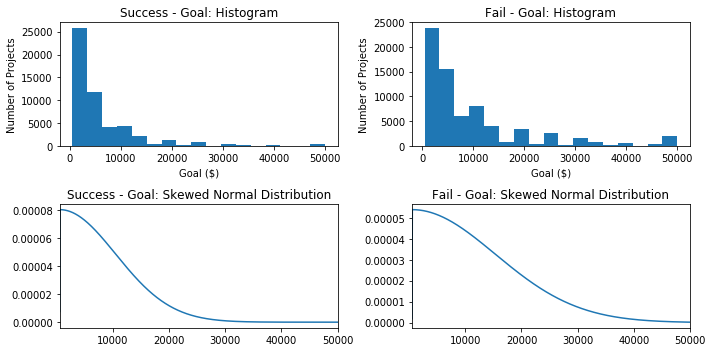

In [17]:
### GOAL CI

print('Successful vs. failed projects goal confidence interval ($)')
x2, x1, x3 = mean_confidence_interval(list(df_success['goal']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df_fail['goal']), 0.95)
print((x2, x1, x3))
print((y2, y1, y3))

fig1 = plt.figure(figsize = (2,6))
plt.bar('Success', x2, yerr = x3-x2, capsize = 10)
plt.bar('Fail', y2, yerr = y3-y2, capsize = 10)
plt.title('Successful vs. failed projects goal confidence interval')
plt.ylabel('Goal ($)')
plt.xticks(rotation = 'vertical')

fig2 = plt.figure(figsize = (10,5))

plt.subplot(2,2,1)
new_lst = [i for i in list(df_success['goal'])]
plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.title('Success - Goal: Histogram')
plt.xlabel('Goal ($)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_fail['goal'])]
plt.subplot(2,2,2)
plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.title('Fail - Goal: Histogram')
plt.xlabel('Goal ($)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Success - Goal: Skewed Normal Distribution')
plt.xlim([500,50000])
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Fail - Goal: Skewed Normal Distribution')
plt.xlim([500,50000])

plt.tight_layout()
plt.show()

Successful vs. failed projects pledged confidence interval ($)
(11656.709255525253, 11172.447061542227, 12140.971449508279)
(721.2949454703881, 706.2577474859208, 736.3321434548554)


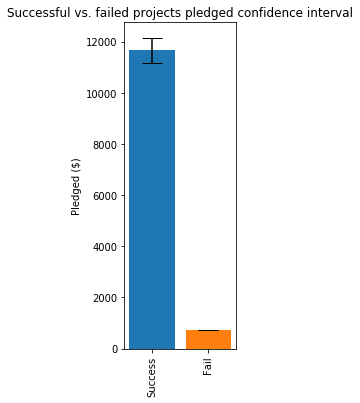

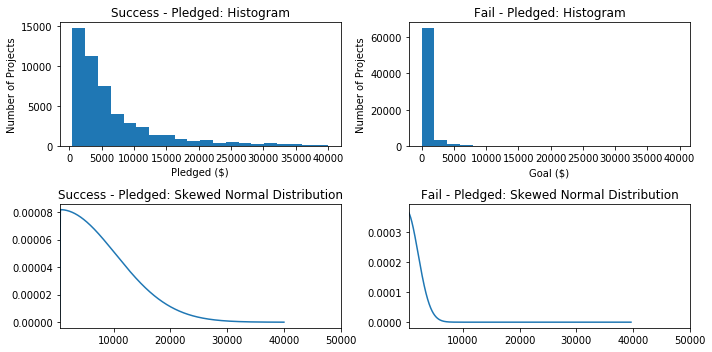

In [38]:
### PLEDGED CI

print('Successful vs. failed projects pledged confidence interval ($)')
x2, x1, x3 = mean_confidence_interval(list(df_success['usd_pledged']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df_fail['usd_pledged']), 0.95)
print((x2, x1, x3))
print((y2, y1, y3))

fig1 = plt.figure(figsize = (2,6))
plt.bar('Success', x2, yerr = x3-x2, capsize = 10)
plt.bar('Fail', y2, yerr = y3-y2, capsize = 10)
plt.title('Successful vs. failed projects pledged confidence interval')
plt.ylabel('Pledged ($)')
plt.xticks(rotation = 'vertical')

fig2 = plt.figure(figsize = (10,5))

plt.subplot(2,2,1)
new_lst = [i for i in list(df_success['usd_pledged']) if i <= 40000]
# plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.hist(new_lst, 20)
plt.title('Success - Pledged: Histogram')
plt.xlabel('Pledged ($)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_fail['usd_pledged']) if i <= 40000]
plt.subplot(2,2,2)
#plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.hist(new_lst1, 20)
plt.title('Fail - Pledged: Histogram')
plt.xlabel('Goal ($)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Success - Pledged: Skewed Normal Distribution')
plt.xlim([500,50000])
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Fail - Pledged: Skewed Normal Distribution')
plt.xlim([500,50000])

plt.tight_layout()
plt.show()

Successful vs. failed projects P/G confidence interval ($)
(1.6806314706925936, 1.6518533491263656, 1.7094095922588215)
(0.0878594866989554, 0.08678680926764144, 0.08893216413026934)


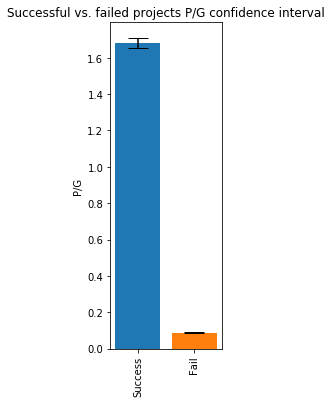

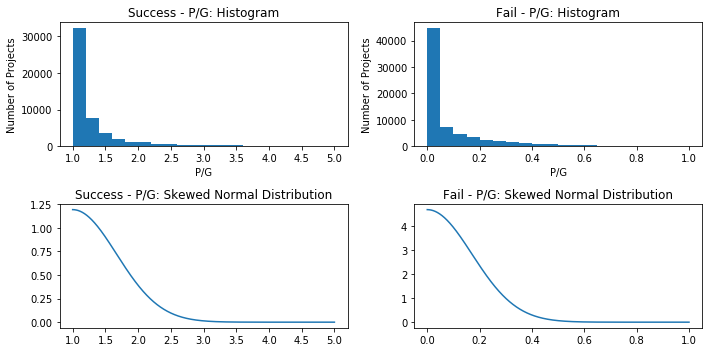

In [40]:
### P/G CI

print('Successful vs. failed projects P/G confidence interval ($)')
x2, x1, x3 = mean_confidence_interval(list(df_success['P/G']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df_fail['P/G']), 0.95)
print((x2, x1, x3))
print((y2, y1, y3))

fig1 = plt.figure(figsize = (2,6))
plt.bar('Success', x2, yerr = x3-x2, capsize = 10)
plt.bar('Fail', y2, yerr = y3-y2, capsize = 10)
plt.title('Successful vs. failed projects P/G confidence interval')
plt.ylabel('P/G')
plt.xticks(rotation = 'vertical')

fig2 = plt.figure(figsize = (10,5))

plt.subplot(2,2,1)
new_lst = [i for i in list(df_success['P/G']) if i <= 5 and i >= 1]
# plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.hist(new_lst, 20)
plt.title('Success - P/G: Histogram')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_fail['P/G']) if i <= 1]
plt.subplot(2,2,2)
#plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.hist(new_lst1, 20)
plt.title('Fail - P/G: Histogram')
plt.xlabel('P/G')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Success - P/G: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Fail - P/G: Skewed Normal Distribution')

plt.tight_layout()
plt.show()

Successful vs. failed projects backers confidence interval ($)
(159.18248847926267, 154.39005432864207, 163.97492262988328)
(11.496064873373246, 11.283378476008638, 11.708751270737855)


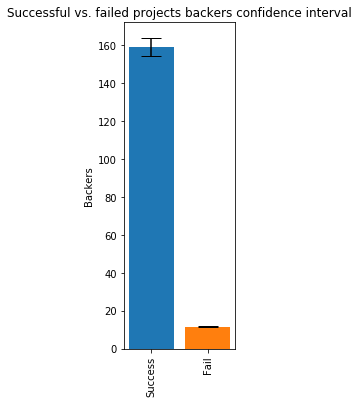

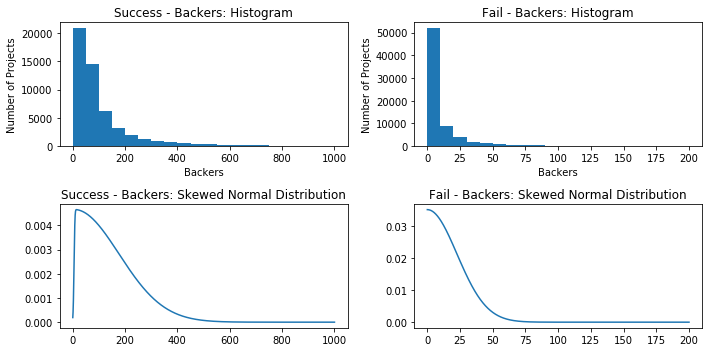

In [44]:
### Backers CI

print('Successful vs. failed projects backers confidence interval ($)')
x2, x1, x3 = mean_confidence_interval(list(df_success['backers_count']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df_fail['backers_count']), 0.95)
print((x2, x1, x3))
print((y2, y1, y3))

fig1 = plt.figure(figsize = (2,6))
plt.bar('Success', x2, yerr = x3-x2, capsize = 10)
plt.bar('Fail', y2, yerr = y3-y2, capsize = 10)
plt.title('Successful vs. failed projects backers confidence interval')
plt.ylabel('Backers')
plt.xticks(rotation = 'vertical')

fig2 = plt.figure(figsize = (10,5))

plt.subplot(2,2,1)
new_lst = [i for i in list(df_success['backers_count']) if i <= 1000]
# plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.hist(new_lst, 20)
plt.title('Success - Backers: Histogram')
plt.xlabel('Backers')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_fail['backers_count']) if i <= 200]
plt.subplot(2,2,2)
#plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.hist(new_lst1, 20)
plt.title('Fail - Backers: Histogram')
plt.xlabel('Backers')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Success - Backers: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Fail - Backers: Skewed Normal Distribution')

plt.tight_layout()
plt.show()

Successful vs. failed projects duration confidence interval ($)
(1.3004761621456893, 1.297358986174344, 1.3035933381170346)
(1.2837240900949074, 1.2810978253619547, 1.28635035482786)


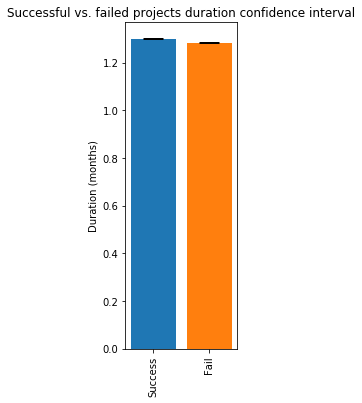

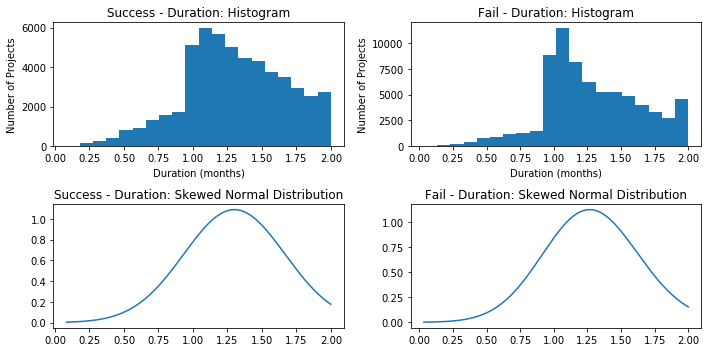

In [43]:
### DURATION CI

print('Successful vs. failed projects duration confidence interval ($)')
x2, x1, x3 = mean_confidence_interval(list(df_success['duration']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df_fail['duration']), 0.95)
print((x2, x1, x3))
print((y2, y1, y3))

fig1 = plt.figure(figsize = (2,6))
plt.bar('Success', x2, yerr = x3-x2, capsize = 10)
plt.bar('Fail', y2, yerr = y3-y2, capsize = 10)
plt.title('Successful vs. failed projects duration confidence interval')
plt.ylabel('Duration (months)')
plt.xticks(rotation = 'vertical')

fig2 = plt.figure(figsize = (10,5))

plt.subplot(2,2,1)
new_lst = [i for i in list(df_success['duration']) if i <= 40000]
# plt.hist(new_lst, bins = round(math.log(len(new_lst),2)) + 1)
plt.hist(new_lst, 20)
plt.title('Success - Duration: Histogram')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Projects')
new_lst1 = [i for i in list(df_fail['duration']) if i <= 40000]
plt.subplot(2,2,2)
#plt.hist(new_lst1, bins = round(math.log(len(new_lst1),2)) + 1)
plt.hist(new_lst1, 20)
plt.title('Fail - Duration: Histogram')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Projects')

x = np.linspace(min(new_lst), max(new_lst), len(new_lst))
plt.subplot(2,2,3)
plt.plot(x, scipy.stats.skewnorm.pdf(x, *scipy.stats.skewnorm.fit(new_lst)))
plt.title('Success - Duration: Skewed Normal Distribution')
x1 = np.linspace(min(new_lst1), max(new_lst1), len(new_lst1))
plt.subplot(2,2,4)
plt.plot(x1, scipy.stats.skewnorm.pdf(x1, *scipy.stats.skewnorm.fit(new_lst1)))
plt.title('Fail - Duration: Skewed Normal Distribution')

plt.tight_layout()
plt.show()